In [1]:
!ls /kaggle/input/journey-springfield

characters_illustration.png  sample_submission.csv  testset  train


# Baseline

In [11]:
import torch

In [12]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [13]:
import pickle
import numpy as np
from skimage import io

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [14]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda") if train_on_gpu else torch.device("cpu")

In [15]:
DEVICE

device(type='cuda')

In [16]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [17]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [18]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [19]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [20]:
val_dataset = SimpsonsDataset(val_files, mode='val')

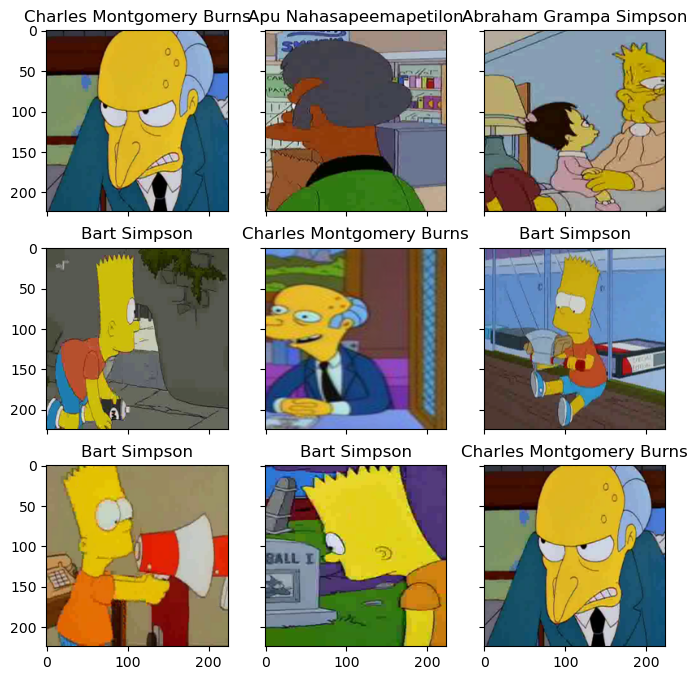

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [22]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [23]:
def fit_epoch(model, train_loader, criterion, optimizer, bar):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    running_acc = 0.0

    for index, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
        running_acc += running_corrects.cpu().numpy() / processed_data
        
        bar.update()
        bar.set_postfix(loss=running_loss/(index + 1), acc=running_acc/(index + 1))
        
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion, bar):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    running_acc = 0.0
    
    for index, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
        running_acc += running_corrects.cpu().numpy() / processed_size
        
        bar.update()
        bar.set_postfix(loss=running_loss/(index + 1), acc=running_acc/(index + 1))
        
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [25]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    epoch_bar = tqdm(desc="epoch", total=epochs, position=0)
    train_bar = tqdm(desc="train", total=int(train_dataset.len_ / batch_size), position=1, leave=True)
    val_bar = tqdm(desc="val", total=int(val_dataset.len_ /batch_size), position=1, leave=True)
    
    opt = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_bar.n = 0
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, train_bar)
        print("loss", train_loss)

        val_bar.n = 0
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, val_bar)
        history.append((train_loss, train_acc, val_loss, val_acc))

        epoch_bar.update()
        epoch_bar.set_postfix(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc)
            
    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [27]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [19]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [20]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/245 [00:00<?, ?it/s]

val:   0%|          | 0/81 [00:00<?, ?it/s]

loss 2.641074237591735
loss 1.6150451969117812
loss 1.0648079953176048
loss 0.7532547098017398
loss 0.5338561080452652


In [21]:
loss, acc, val_loss, val_acc = zip(*history)

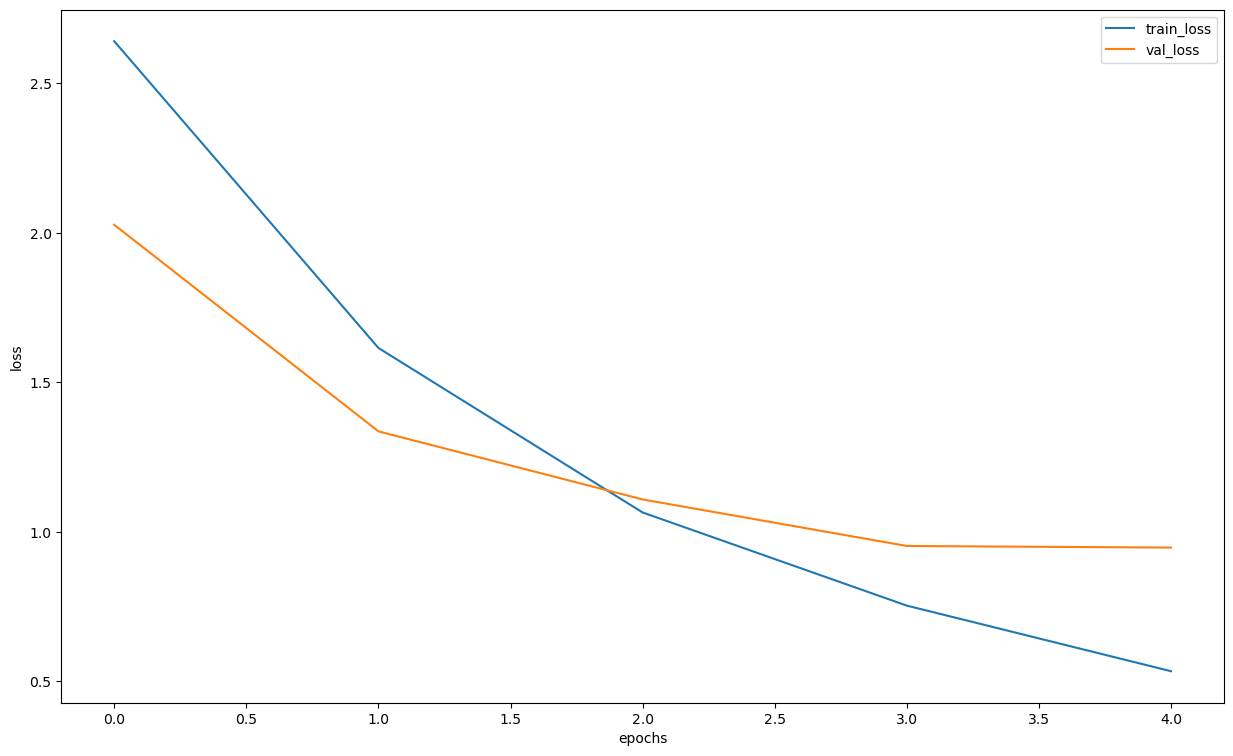

In [22]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [25]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [26]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [27]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [28]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [29]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average=None)

array([0.75      , 1.        , 0.        , 0.72727273, 0.83333333,
       0.        , 0.        , 0.        ])

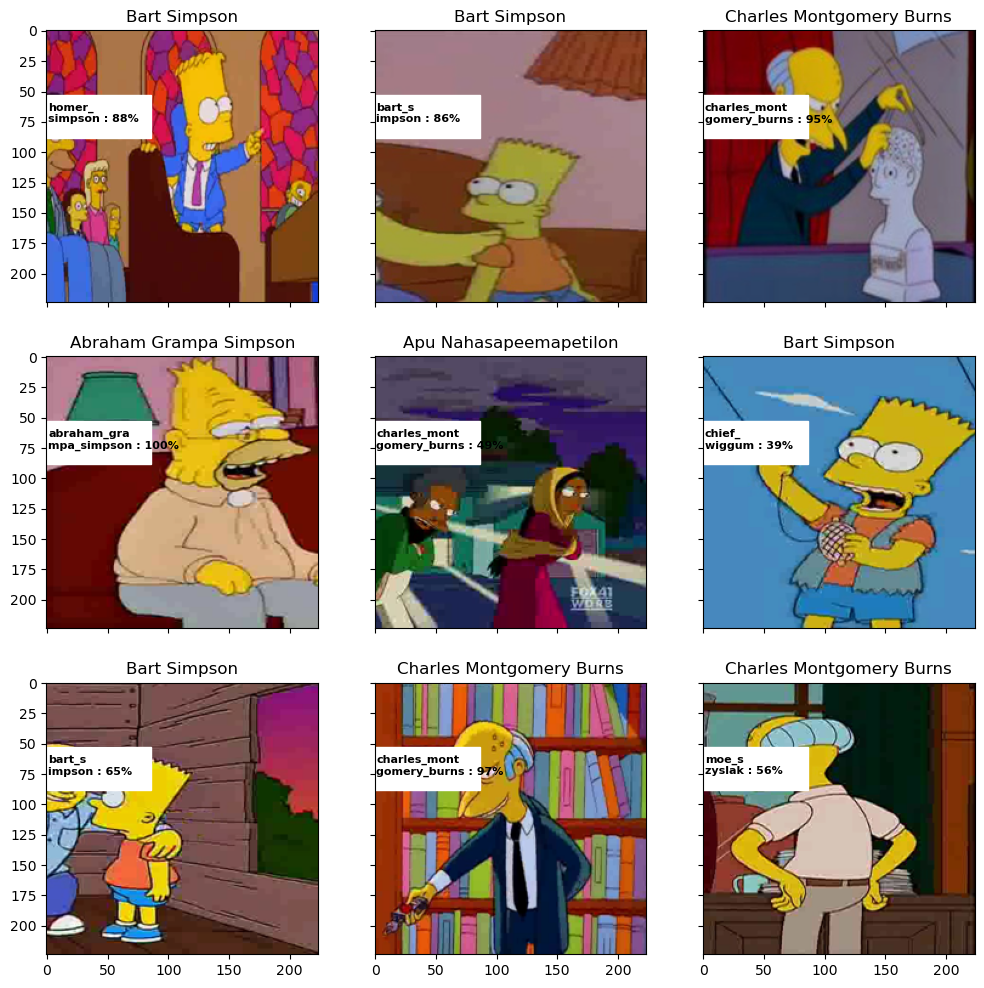

In [30]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [31]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [33]:
import pandas as pd
pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv").head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [34]:
import pandas as pd
my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [35]:
my_submit.to_csv('/kaggle/working/simple_cnn_baseline.csv', index=False) # -> 0.8735x 

# Now with augmentations and different lr

In [1]:
import pickle
import numpy as np
from skimage import io

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from torchvision import transforms, datasets
import torch
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import f1_score

In [2]:
torch.cuda.empty_cache()
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [3]:
torch.cuda.empty_cache()

In [4]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/')
BATCH_SIZE = 32

In [5]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, train_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, test_transform)

In [7]:
# split
train_indices, val_indices = train_test_split(list(range(len(train_dataset))), train_size = 0.85)

In [8]:
len(train_indices) + len(val_indices)

20933

In [9]:
max(val_indices), max(train_indices), min(val_indices), min(train_indices)

(20932, 20931, 2, 0)

In [10]:
len(train_dataset)

20933

In [11]:
#train_dataset = Subset(train_dataset, train_indices)
#val_dataset = Subset(train_dataset, val_indices)

In [12]:
#c = Counter()
#for _, cl in train_dataset:
#    c[cl] += 1
#print(c)

In [13]:
#weights = [1/c.get(cl) for _, cl in train_dataset]

In [14]:
#sampler = torch.utils.data.WeightedRandomSampler(weights, num_samples=len(weights))

In [15]:
#train_dataset = datasets.ImageFolder(TRAIN_DIR, train_transform)
#test_dataset = datasets.ImageFolder(TEST_DIR, test_transform)

In [16]:
# dataloaders
train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
val_loader = DataLoader(Subset(train_dataset, val_indices), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [17]:
next(iter(val_loader))

[tensor([[[[-0.5253, -0.5253, -0.5253,  ..., -0.5253, -0.5253, -0.5253],
           [-0.5253, -0.5253, -0.5253,  ..., -0.5253, -0.5253, -0.5253],
           [-0.5253, -0.5253, -0.5253,  ..., -0.5253, -0.5253, -0.5253],
           ...,
           [ 0.0912, -0.0972,  0.0569,  ...,  0.5707,  0.5707,  0.5707],
           [-0.1143, -0.4226, -0.5253,  ...,  0.7419,  0.7419,  0.7419],
           [-0.1314, -0.3027, -0.5424,  ...,  0.6221,  0.6221,  0.6221]],
 
          [[ 0.4328,  0.4328,  0.4328,  ...,  0.4328,  0.4328,  0.4328],
           [ 0.4328,  0.4328,  0.4328,  ...,  0.4328,  0.4328,  0.4328],
           [ 0.4328,  0.4328,  0.4328,  ...,  0.4328,  0.4328,  0.4328],
           ...,
           [ 0.3277,  0.2752,  0.4328,  ...,  0.9230,  0.9230,  0.9230],
           [ 0.1176, -0.0574, -0.1450,  ...,  0.9755,  0.9755,  0.9755],
           [ 0.0126, -0.0574, -0.2325,  ...,  0.7829,  0.7829,  0.7829]],
 
          [[ 1.8034,  1.8034,  1.8034,  ...,  1.8034,  1.8034,  1.8034],
           [ 

In [23]:
# model
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [29]:
from sklearn.metrics import f1_score

In [18]:
def fit_epoch(model, train_loader, criterion, optimizer, bar):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    running_acc = 0.0
    running_f1 = 0.0

    for index, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
        running_acc += running_corrects.cpu().numpy() / processed_data
        
        running_f1 += f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')
        
        bar.update()
        bar.set_postfix(loss=running_loss/(index + 1), acc=running_acc/(index + 1), f1=running_f1 / (index + 1))
        
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    train_f1 = running_f1 / (index + 1)
    return train_loss, train_acc, train_f1

In [19]:
def eval_epoch(model, val_loader, criterion, bar):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    running_acc = 0.0
    running_f1 = 0.0
    
    for index, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
        running_acc += running_corrects.cpu().numpy() / processed_size
        
        running_f1 += f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro')
        
        bar.update()
        bar.set_postfix(loss=running_loss/(index + 1), acc=running_acc/(index + 1), f1=running_f1 / (index + 1))
        
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    val_f1 = running_f1 / (index + 1)
    return val_loss, val_acc, val_f1

In [28]:
def train(train_loader, val_loader, model, epochs, batch_size, lr=3e-4):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    epoch_bar = tqdm(desc="epoch", total=epochs, position=0)
    train_bar = tqdm(desc="train", total=len(train_loader), position=1, leave=True)
    val_bar = tqdm(desc="val", total=len(val_loader), position=1, leave=True)
    
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=opt, step_size=7, gamma=0.5)
    
    for epoch in range(epochs):
        train_bar.n = 0
        train_loss, train_acc, train_f1 = fit_epoch(model, train_loader, criterion, opt, train_bar)
        print(f"epoch {epoch}, loss {train_loss}, f1 {train_f1}")

        val_bar.n = 0
        val_loss, val_acc, val_f1 = eval_epoch(model, val_loader, criterion, val_bar)
        history.append((train_loss, train_acc, train_f1, val_loss, val_acc, val_f1))
        print(f"epoch {epoch}, loss {val_loss}, f1 {val_f1}")

        if epoch == 0:
            best_loss = val_loss
            best_model_dict = model.state_dict()
        elif best_loss > val_loss:
            best_model_dict = model.state_dict()
            
        
        
        epoch_bar.update()
        epoch_bar.set_postfix(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, t_f1=train_f1, v_f1=val_f1)
        
        scheduler.step()
        
    model.load_state_dict(best_model_dict)
        
    return history

In [38]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs[0] = inputs[0].to(DEVICE)
            model.eval()
            outputs = model(inputs[0]).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [18]:
n_classes = len(train_dataset.classes)
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

NameError: name 'SimpleCnn' is not defined

In [64]:
history = train(train_loader, val_loader, model=simple_cnn, epochs=20, batch_size=64, lr=3e-4)

NameError: name 'simple_cnn' is not defined

In [65]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

NameError: name 'history' is not defined

In [66]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

NameError: name 'val_dataset' is not defined

In [67]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

NameError: name 'val_dataset' is not defined

In [68]:
probs = predict(simple_cnn, test_loader)


preds = np.argmax(probs, axis=1)

NameError: name 'simple_cnn' is not defined

In [69]:
idx_to_class = {
    idx: c 
    for c, idx in train_dataset.class_to_idx.items()
}

In [70]:
preds = [idx_to_class[idx] for idx in preds]

NameError: name 'preds' is not defined

In [2]:
import pandas as pd
my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': my_submit.Id, 'Expected': preds})
my_submit.head()

NameError: name 'preds' is not defined

In [ ]:
my_submit.to_csv('/kaggle/working/simple_cnn_baseline.csv', index=False)

# Efficient net fine tune

> 

In [21]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=2d17f16e45c42a4296c37f48d465f84ac820ee29c824c0eb9b7f20ef266c676c
  Stored in directory: /root/.cache/pip/wheels/96/3f/5f/13976445f67f3b4e77b054e65f7f4c39016e92e8358fe088db
Successfully built efficientnet_pytorch


In [29]:
import efficientnet_pytorch

In [30]:
model = efficientnet_pytorch.EfficientNet.from_pretrained("efficientnet-b1")

Loaded pretrained weights for efficientnet-b1


In [31]:
classes = train_dataset.classes

In [32]:
model.classifier = nn.Sequential(
    nn.Linear(1208, len(classes)),
)
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [33]:
n_classes = len(classes)
model = model.to(DEVICE)
print("we will classify :{}".format(n_classes))

we will classify :42


In [34]:
history = train(train_loader, val_loader, model=model, epochs=20, batch_size=128, lr=1e-4)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/557 [00:00<?, ?it/s]

val:   0%|          | 0/99 [00:00<?, ?it/s]

epoch 0, loss 2.136847404915627, f1 0.44956166744298603
epoch 0, loss 0.8660173287057573, f1 0.6852696166501729
epoch 1, loss 0.6992296861307835, f1 0.7235675007001652
epoch 1, loss 0.6340463597902873, f1 0.7566474911473207
epoch 2, loss 0.5316838126610538, f1 0.7808085385896355
epoch 2, loss 0.5763788523609233, f1 0.7829938865209085
epoch 3, loss 0.442475912659275, f1 0.8219599990739035
epoch 3, loss 0.47406943839067106, f1 0.8066493900248647
epoch 4, loss 0.3988363295839594, f1 0.8328278384491115
epoch 4, loss 0.45816958759241044, f1 0.8088554322542731
epoch 5, loss 0.36733083294959545, f1 0.8559296892161984
epoch 5, loss 0.4347998645654909, f1 0.8271546297979387
epoch 6, loss 0.33797019167407993, f1 0.8627733556610877
epoch 6, loss 0.4233075060472367, f1 0.8152704327137661
epoch 7, loss 0.2896555957162032, f1 0.8805180112025752
epoch 7, loss 0.349735619665782, f1 0.8571212078410605
epoch 8, loss 0.2773660358745457, f1 0.8836497029382067
epoch 8, loss 0.36603473861268754, f1 0.863530

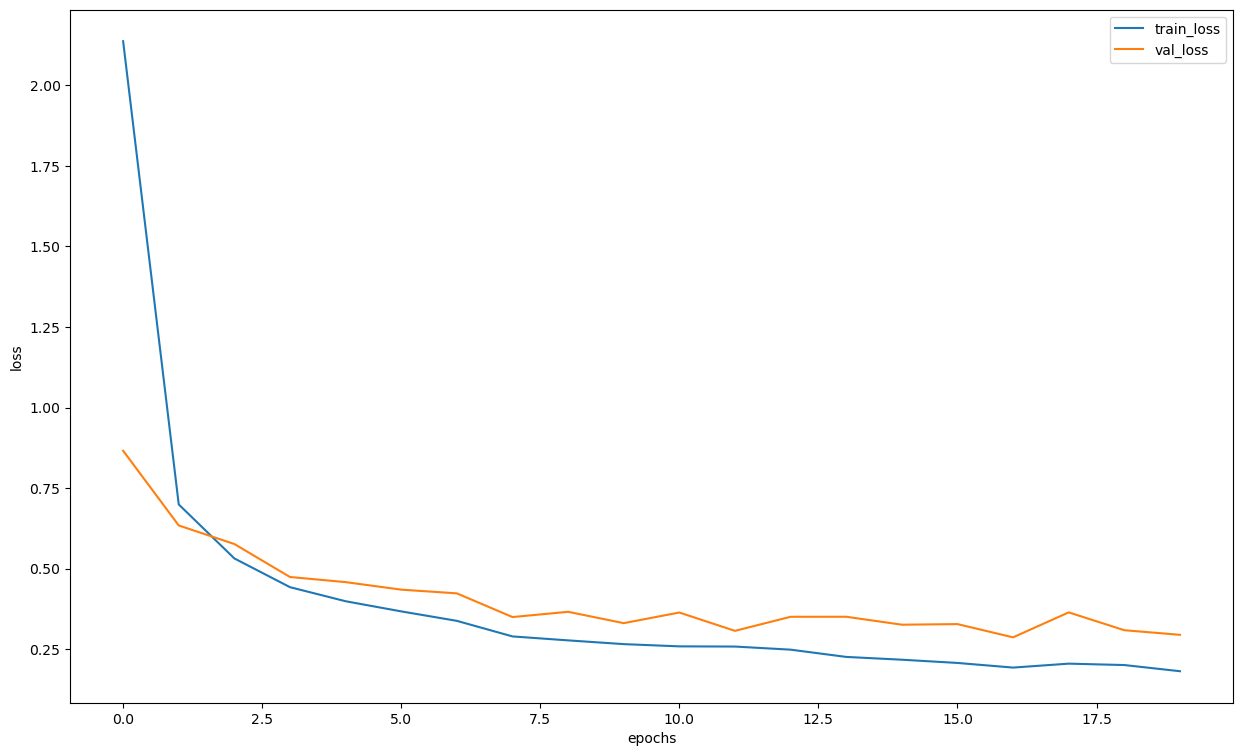

In [36]:
loss, acc, f1, val_loss, val_acc, val_f1 = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [43]:
test_filenames = [filename[0].split('/')[-1] for filename in test_dataset.imgs]

['img0.jpg',
 'img1.jpg',
 'img10.jpg',
 'img100.jpg',
 'img101.jpg',
 'img102.jpg',
 'img103.jpg',
 'img104.jpg',
 'img105.jpg',
 'img106.jpg',
 'img107.jpg',
 'img108.jpg',
 'img109.jpg',
 'img11.jpg',
 'img110.jpg',
 'img111.jpg',
 'img112.jpg',
 'img113.jpg',
 'img114.jpg',
 'img115.jpg',
 'img116.jpg',
 'img117.jpg',
 'img118.jpg',
 'img119.jpg',
 'img12.jpg',
 'img120.jpg',
 'img121.jpg',
 'img122.jpg',
 'img123.jpg',
 'img124.jpg',
 'img125.jpg',
 'img126.jpg',
 'img127.jpg',
 'img128.jpg',
 'img129.jpg',
 'img13.jpg',
 'img130.jpg',
 'img131.jpg',
 'img132.jpg',
 'img133.jpg',
 'img134.jpg',
 'img135.jpg',
 'img136.jpg',
 'img137.jpg',
 'img138.jpg',
 'img139.jpg',
 'img14.jpg',
 'img140.jpg',
 'img141.jpg',
 'img142.jpg',
 'img143.jpg',
 'img144.jpg',
 'img145.jpg',
 'img146.jpg',
 'img147.jpg',
 'img148.jpg',
 'img149.jpg',
 'img15.jpg',
 'img150.jpg',
 'img151.jpg',
 'img152.jpg',
 'img153.jpg',
 'img154.jpg',
 'img155.jpg',
 'img156.jpg',
 'img157.jpg',
 'img158.jpg',
 'img

In [45]:
probs = predict(model, test_loader)
preds = np.argmax(probs, axis=1)
idx_to_class = {
    idx: c 
    for c, idx in train_dataset.class_to_idx.items()
}
preds = [idx_to_class[idx] for idx in preds]
import pandas as pd
my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.iloc[0:10]

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman
6,img103.jpg,edna_krabappel
7,img104.jpg,chief_wiggum
8,img105.jpg,lisa_simpson
9,img106.jpg,kent_brockman


In [46]:
my_submit.to_csv('/kaggle/working/simple_cnn_baseline.csv', index=False) # -> 0.99681